In [26]:
# import all methods

from pyspark.sql import SparkSession
from data_processing import get_processed_data, save_dataset_to_db, get_data_set_from_db
from analysis import process_df, vectorize_data, stardize_data, perform_cross_validation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
# Database variables
database_name = 'distritos'
database_user_name = 'postgres'
database_password = '123'
database_table = 'distritos'

# Other variables
features = ['POBLACION_2016', 'IDS', 'DENSIDAD', 'TCP',
            'CTM', 'CPPR', 'CPRU', 'CPHM', 'CPEXM',
            'TASA_ASALTO', 'TASA_HOMICIDIO', 'TASA_HURTO', 'TASA_ROBO']
label = 'CTAA'
features_standard = 'features_starndard'

In [28]:
# Merging and processsing all data

spark = SparkSession.builder.appName('database').master('local')\
                            .appName("Basic JDBC pipeline") \
                            .config("spark.driver.extraClassPath", "postgresql-42.1.4.jar") \
                            .config("spark.executor.extraClassPath", "postgresql-42.1.4.jar") \
                            .getOrCreate()


distritos_df = get_processed_data(spark, 'data/distritos.csv', 'data/crimenes.csv',
                               'data/escuelas.csv', 'data/colegios.csv',
                               'data/extranjeros_escuelas.csv', 'data/extranjeros_colegios.csv',
                               'data/processed/dataset.csv')

distritos_df.select(['POBLACION_2016', 'IDS', 'TASA_ROBO', 'CTAA']).show()

+--------------+-----+--------------------+------------------+
|POBLACION_2016|  IDS|           TASA_ROBO|              CTAA|
+--------------+-----+--------------------+------------------+
|          3090|81.16|0.022977346278317153|0.9536082474226805|
|         14721|67.73|0.006928877114326473|             0.828|
|         22895| 62.5|  0.0052413190652981| 0.779136690647482|
|         15308|76.17|0.006271230729030572|0.8231524989320803|
|         21460|82.86|0.001071761416589...|0.8853585229712323|
|         23269|82.87|0.001676049679831...|0.9538461538461539|
|         39443|63.87|0.001977537205587...|0.8968253968253969|
|          9895|93.16|0.004244567963617989| 0.912375790424571|
|         84102|73.72|0.001545742075099...|0.8381390840804458|
|         57902|68.71|6.217401816862975E-4|0.7693251533742331|
|         44707|76.19|0.001409175296933366|0.9278846153846154|
|         13529|91.54|8.130682238155074E-4|0.8635097493036211|
|         26397| 80.9|0.001136492783270...|0.8693528693

In [29]:
# Saving and getting it from the database

save_dataset_to_db(distritos_df, database_name, database_user_name, database_password, database_table)

distritos_df = get_data_set_from_db(spark, database_name, database_user_name, database_password, database_table)


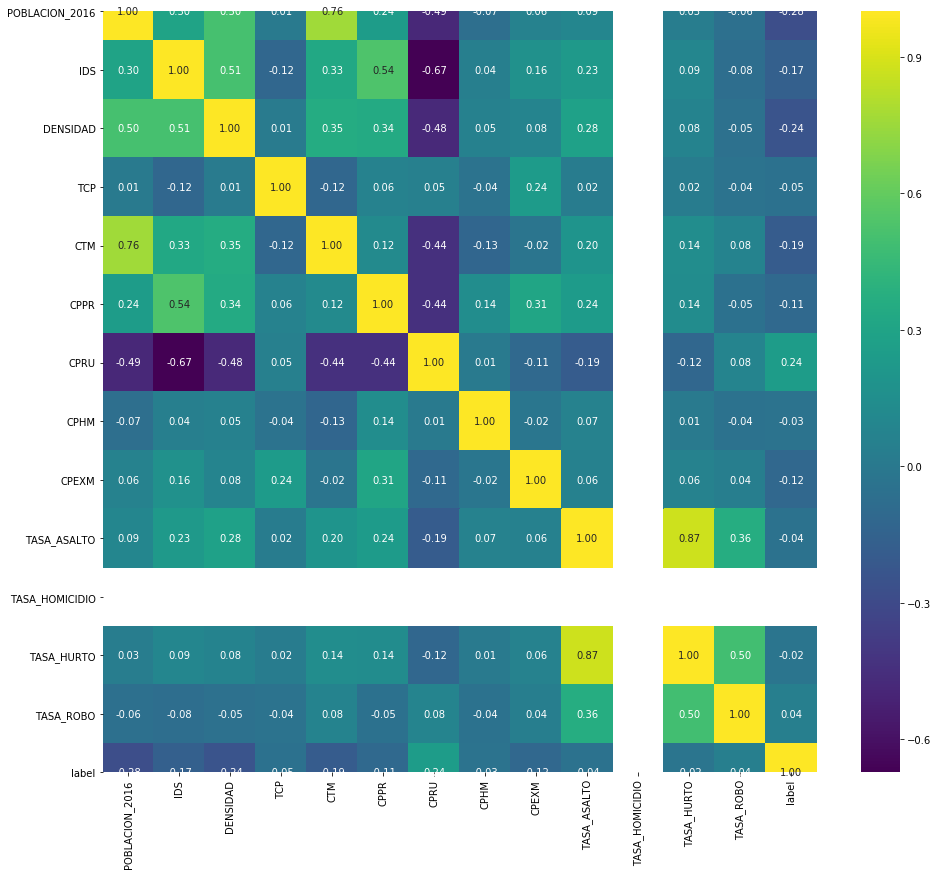

In [30]:
# Show the Pearson Matrix

df = process_df(distritos_df, features + [label], label)
pands_df = df.toPandas()
df = vectorize_data(df, features)
df = stardize_data(df, features_standard)

#pearson_matrix = Correlation.corr(df, 'features').collect()[0][0]
pearson_matrix = pands_df.corr()

plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(pearson_matrix, fmt=".2f", cmap='viridis', annot=True)
plt.show()

In [32]:
# Train and evaluate a Linear Regression Model

train, test = df.randomSplit([0.9, 0.1])
lr = LinearRegression(featuresCol=features_standard, labelCol='label')

cv_model = perform_cross_validation(train, lr)

evaluation_summary = cv_model.bestModel.evaluate(test)

print('R2: ', evaluation_summary.r2)
print('MSE: ', evaluation_summary.meanSquaredError)

R2:  0.20918502934244276
MSE:  0.005446704226317677
